In [1]:
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import pandas as pd
from tqdm.notebook import tqdm

import numpy as np
#np.random.seed(0)

from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
import matplotlib.pyplot as plt
%matplotlib inline
from myDiffusion import IndependentCascadesModel

adj = pd.read_csv("adj.csv")

no display found. Using non-interactive Agg backend


In [2]:
# bc = pd.read_csv(f"bc_{group}.csv")
# links
# np.where(bc.betweenness_centrality>0)[0]

# 1. Define initial active nodes

In [3]:
infected_nodes = {}
for group in ["Liu Yu", "Mika"]:
    infected_nodes[group] = {}
    links = adj[adj[group]].drop(group,axis=1).drop_duplicates(ignore_index=True)
    g = nx.from_pandas_edgelist(links, source="m_node", target="node", create_using=nx.DiGraph)
    
    for i_group, deg in zip(["degree", "in_degree", "out_degree", "random"], [g.degree(), g.in_degree(), g.out_degree()]):
        temp = sorted(deg, key=lambda x: x[1], reverse=True)
        infected_nodes[group][i_group] = np.array(temp)[:,0]
    
    # Random
    temp = list(g.nodes)
    np.random.shuffle(temp)
    infected_nodes[group]["random"] =  temp

In [4]:
for group in ["Liu Yu", "Mika"]:
    for i_group in ["degree", "in_degree", "out_degree", "random"]:
        print(infected_nodes[group][i_group][:10], group,i_group)

[53677 54146 55173 56045 54371 54149 53701 55534 55256 55565] Liu Yu degree
[ 5988 54233 54019 54204 56215 35678 39478 48688 19380   776] Liu Yu in_degree
[53677 54146 55173 56045 54371 54149 53701 55534 55256 54147] Liu Yu out_degree
[3755, 46074, 46928, 3042, 12086, 15651, 39471, 44947, 37018, 29722] Liu Yu random
[53677 57117 56232 54371 55891 54254 54247 54677 55173 56397] Mika degree
[42643 50617 56397 56871 53837 54766 54113 54411 55364 54044] Mika in_degree
[53677 57117 56232 54371 55891 54254 54247 54677 55173 55283] Mika out_degree
[13413, 49942, 8281, 4773, 32096, 33088, 48150, 6640, 53813, 1389] Mika random


# 2. Run diffusion experiments

In [5]:
# Model selection
all_trs = {}
init_ns = [10, 100, 200, 500, 1000]
threshold = 0.5
ITERATIONS = 20

for group in ["Liu Yu", "Mika"]:
    all_trs[group] = {}
    links = adj[adj[group]].drop(group,axis=1).drop_duplicates(ignore_index=True)
    g = nx.from_pandas_edgelist(links, source="m_node", target="node", create_using=nx.DiGraph)
    all_trs[group]["n_nodes"] = len(g.nodes())
    
    for m in ["TM", "ICM"]:
        all_trs[group][m] = {}
        for i_group in ["degree", "in_degree", "out_degree", "random"]:
            trs = []
            for init_n in init_ns:
                config = mc.Configuration()
                config.add_model_initial_configuration("Infected", infected_nodes[group][i_group][:init_n])

                if m == "TM":
                    model = ep.ThresholdModel(g)
                    for i in g.nodes():
                        config.add_node_configuration("threshold", i, threshold)

                elif m == "ICM":
                    model = IndependentCascadesModel(g)
                    for e in g.edges():
                        config.add_edge_configuration("threshold", e, threshold)


                model.set_initial_status(config)
                # Simulation execution
                iterations = model.iteration_bunch(ITERATIONS)

                # Plot Trend
                trends = model.build_trends(iterations)

                trs.append(trends[0]["trends"]["node_count"][1])
                #viz = DiffusionTrend(model, trends)
                #viz.plot()
                #plt.plot(trs[0])

            all_trs[group][m][i_group] = trs

100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


# 3. Evaluate

In [6]:
def inverse(x):
    return x

Liu Yu | TM  degree | N0 = 1000: #active node=27154 (0.96)| N0=10: 22669 (0.80)
Liu Yu | TM  out_degree | N0 = 1000: #active node=27685 (0.98)| N0=10: 22669 (0.80)
Liu Yu | TM  in_degree | N0 = 1000: #active node=5618 (0.20)| N0=10: 30 (0.00)
Liu Yu | TM  random | N0 = 1000: #active node=1149 (0.04)| N0=10: 10 (0.00)
Liu Yu | ICM  degree | N0 = 1000: #active node=27174 (0.96)| N0=10: 23609 (0.83)
Liu Yu | ICM  out_degree | N0 = 1000: #active node=27692 (0.98)| N0=10: 23609 (0.83)
Liu Yu | ICM  in_degree | N0 = 1000: #active node=14687 (0.52)| N0=10: 14685 (0.52)
Liu Yu | ICM  random | N0 = 1000: #active node=15220 (0.54)| N0=10: 10 (0.00)


/opt/conda/envs/rapids/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


Mika | TM  degree | N0 = 1000: #active node=44142 (0.96)| N0=10: 38538 (0.84)
Mika | TM  out_degree | N0 = 1000: #active node=44590 (0.97)| N0=10: 32298 (0.70)
Mika | TM  in_degree | N0 = 1000: #active node=17810 (0.39)| N0=10: 747 (0.02)
Mika | TM  random | N0 = 1000: #active node=1131 (0.02)| N0=10: 11 (0.00)
Mika | ICM  degree | N0 = 1000: #active node=44196 (0.96)| N0=10: 40186 (0.88)
Mika | ICM  out_degree | N0 = 1000: #active node=44614 (0.97)| N0=10: 40186 (0.88)
Mika | ICM  in_degree | N0 = 1000: #active node=27388 (0.60)| N0=10: 27387 (0.60)
Mika | ICM  random | N0 = 1000: #active node=27833 (0.61)| N0=10: 15 (0.00)


/opt/conda/envs/rapids/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


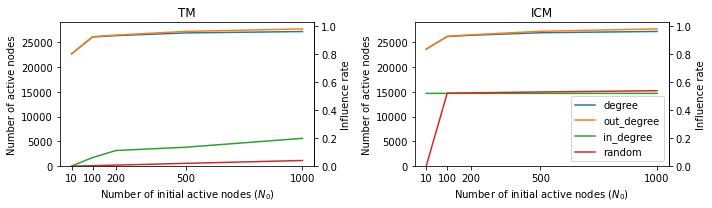

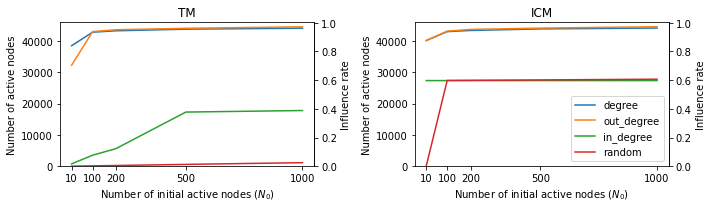

In [7]:
for group in ["Liu Yu", "Mika"]:
    fig, axes = plt.subplots(1,2, constrained_layout=True, figsize=(10,3))
    #fig.set_title(group)
    N_NODES = all_trs[group]["n_nodes"]
    def forward(x, N_NODES=N_NODES):
        return (x/N_NODES)
        
    for p_i, m in enumerate(["TM", "ICM"]):
        for i_group in ["degree", "out_degree", "in_degree", "random"]:
        #for i_group in ["degree",  "random"]:    
            _ = axes[p_i].plot(init_ns, np.array(all_trs[group][m][i_group])[:, -1], label=i_group)
            temp = np.array(all_trs[group][m][i_group])[-1, -1]
            temp2 = np.array(all_trs[group][m][i_group])[0, -1]
            print(f"{group} | {m}  {i_group} | N0 = 1000: #active node={temp} ({temp/N_NODES:.2f})| N0=10: {temp2} ({temp2/N_NODES:.2f})")
        secax = axes[p_i].secondary_yaxis(1, functions=(forward, inverse))
        _ = axes[p_i].set_ylabel("Number of active nodes")
        _ = axes[p_i].set_xlabel("Number of initial active nodes ($N_0$)")
        _ = axes[p_i].set_xticks(init_ns)
        _ = secax.set_ylabel("Influence rate")
        if p_i == 1:
            _ = axes[p_i].legend()
        _ = axes[p_i].set_title(m)
        _ = axes[p_i].set_ylim(0, np.ceil(N_NODES/1000)*1000)
        
        
    plt.tight_layout()
    plt.savefig(f"fig/diffusion_{group}.png")